Nov.10 2020, Adi Watzman & Eyal Berger. Based on a code by Dan Bareket. 

V2 - compare a recent date (Nov.9, >14PM) and export out feedback to send MoT.

======

Parse 1 day of data to compare Siri 2.7 to 2.8 versions.  
2.7 is the current "production" version for us, base on siri_retreiver Java code that queries MoT's servers for all last stops.   
2.8 is a new version, that allows MUCH simpler query, and get all currently driving buses without any quering hack.   
However, we want to make sure we get the same data with both versions before we switch to 2.8 for "production".

In V1 we saw a lot of points and rides missing in 2.8 comparing to 2.7, for Sep. 15.

The data was manually downloaded from our S3 server.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import pandas as pd
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')

In [3]:
import datetime as dt

In [4]:
data_dir = '/Users/awatzman/Documents/OpenBusDocuments/data/' \
           '2020-10-12_compare_siri_2.7_2.8'
siri_27_dir = join(data_dir, 'siri_27_2020-11-09') # csv.gz files
siri_28_dir = join(data_dir, 'siri_28_2020-11-09') # tar.gz file per hour, each with ~120 json.gz files


In [5]:
! ls $siri_27_dir | grep csv | wc -l

       9


In [6]:
! ls $siri_28_dir | grep tar | wc -l

      10


In [7]:
! ls $siri_28_dir | grep tar 

2020-11-09_14.tar.gz
2020-11-09_15.tar.gz
2020-11-09_16.tar.gz
2020-11-09_17.tar.gz
2020-11-09_18.tar.gz
2020-11-09_19.tar.gz
2020-11-09_20.tar.gz
2020-11-09_21.tar.gz
2020-11-09_22.tar.gz
2020-11-09_23.tar.gz


In [25]:
# # unpack 2.8 tar files: (was done manually)
# ! gtar -zxvf $siri_28_dir/*.tar.gz

gtar: /Users/awatzman/Documents/OpenBusDocuments/data/2020-10-12_compare_siri_2.7_2.8/siri_28_2020-11-09/2020-11-09_15.tar.gz: Not found in archive
gtar: /Users/awatzman/Documents/OpenBusDocuments/data/2020-10-12_compare_siri_2.7_2.8/siri_28_2020-11-09/2020-11-09_16.tar.gz: Not found in archive
gtar: /Users/awatzman/Documents/OpenBusDocuments/data/2020-10-12_compare_siri_2.7_2.8/siri_28_2020-11-09/2020-11-09_17.tar.gz: Not found in archive
gtar: /Users/awatzman/Documents/OpenBusDocuments/data/2020-10-12_compare_siri_2.7_2.8/siri_28_2020-11-09/2020-11-09_18.tar.gz: Not found in archive
gtar: /Users/awatzman/Documents/OpenBusDocuments/data/2020-10-12_compare_siri_2.7_2.8/siri_28_2020-11-09/2020-11-09_19.tar.gz: Not found in archive
gtar: /Users/awatzman/Documents/OpenBusDocuments/data/2020-10-12_compare_siri_2.7_2.8/siri_28_2020-11-09/2020-11-09_20.tar.gz: Not found in archive
gtar: /Users/awatzman/Documents/OpenBusDocuments/data/2020-10-12_compare_siri_2.7_2.8/siri_28_2020-11-09/2020-11

# Read 2.8 files

In [8]:
from siri_parser import read_siri28_file, read_siri28_files, SIRI28_TYPES

In [86]:
# %%time
# df_28_day = read_siri28_files(siri_28_dir, max_files=None, suf='.json')
# df_28_day.shape

/Users/awatzman/Documents/OpenBusDocuments/data/2020-10-12_compare_siri_2.7_2.8/siri_28_2020-11-09/18/siri_snap_normal_2020-11-09T183631.json Expecting value: line 1 column 1 (char 0)
CPU times: user 10min 49s, sys: 20.6 s, total: 11min 9s
Wall time: 11min 11s


In [87]:
# df_28_day.to_feather('df_28_20201109.feather')

In [9]:
df_28_day = pd.read_feather('df_28_20201109.feather')
df_28_day.shape

(5673709, 26)

In [10]:
dt_cols = [col for col in df_28_day.columns 
           if pd.api.types.is_datetime64_ns_dtype(df_28_day[col])]
df_28_day[dt_cols].dtypes

recorded_at_time               datetime64[ns, pytz.FixedOffset(120)]
origin_aimed_departure_time    datetime64[ns, pytz.FixedOffset(120)]
expected_arrival_time          datetime64[ns, pytz.FixedOffset(120)]
aimed_arrival_time             datetime64[ns, pytz.FixedOffset(120)]
response_timestamp             datetime64[ns, pytz.FixedOffset(120)]
dtype: object

In [11]:
# remove timezone data, keep the time as-is to compare to 2.7 that has no timezone data
for col in dt_cols:
    df_28_day[col] = df_28_day[col].dt.tz_localize(None)

In [12]:
df_28_day.dtypes

recorded_at_time               datetime64[ns]
item_identifier                         int64
monitoring_ref                          int64
line_ref                                int64
direction_ref                           int64
data_frame_ref                         object
dated_vehicle_journey_ref               int64
published_line_name                    object
operator_ref                         category
destination_ref                         int64
origin_aimed_departure_time    datetime64[ns]
longitude                             float32
latitude                              float32
bearing                                 int64
velocity                                int64
vehicle_ref                             int64
stop_point_ref                          int64
order                                   int64
expected_arrival_time          datetime64[ns]
distance_from_stop                      int64
aimed_arrival_time             datetime64[ns]
arrival_status                    

In [13]:
# number of rides:
# By: agency, route, bus, start_time
df_28_day.drop_duplicates([
    'operator_ref', 'line_ref', 'vehicle_ref', 
    'origin_aimed_departure_time'], keep='first').shape

(38894, 26)

In [14]:
# number of rides without 0:
# By: agency, route, bus, start_time
df_28_rides = df_28_day[df_28_day.latitude != 0].groupby([
    'operator_ref', 'line_ref', 'vehicle_ref', 
    'origin_aimed_departure_time']).size()

# df_28_rides = df_28_day2[df_28_day2.latitude != 0].drop_duplicates([
#     'operator_ref', 'line_ref', 'vehicle_ref', 
#     'origin_aimed_departure_time'], keep='first')
df_28_rides.shape

(38894,)

2.8 does not have entire 0 rides.

In [15]:
# number of responses deduped (GPS points) without 0:
# By: agency, route, bus, start_time, recorded_at_time
df_28_day_dedup = df_28_day[df_28_day.latitude != 0].drop_duplicates([
    'operator_ref', 'line_ref', 'vehicle_ref', 
    'origin_aimed_departure_time', 'recorded_at_time'], 
    keep='first')
df_28_day_dedup.shape

(1052395, 26)

In [16]:
# number of responses deduped (GPS points) without 0, ride starts after 14PM:
# By: agency, route, bus, start_time, recorded_at_time
df_28_final_dedup = df_28_day[
    (df_28_day.latitude != 0) &
    (df_28_day.recorded_at_time.dt.day == 9) &
    (df_28_day.recorded_at_time.dt.hour >= 14)
    ].drop_duplicates([
    'operator_ref', 'line_ref', 'vehicle_ref', 
    'origin_aimed_departure_time', 'recorded_at_time'], 
    keep='first')
df_28_final_dedup.shape

(1030764, 26)

In [17]:
df_28_final_rides = df_28_final_dedup.groupby([
    'operator_ref', 'line_ref', 'vehicle_ref', 
    'origin_aimed_departure_time'])\
    .recorded_at_time.count()\
    .rename('points_cnt').reset_index(drop=False)
df_28_final_rides.shape

(38395, 5)

# Read 2.7 files

In [18]:
from siri_parser import read_siri27_files

In [19]:
%%time
df_27_day = read_siri27_files(siri_27_dir, max_files=None)

CPU times: user 8.58 s, sys: 874 ms, total: 9.46 s
Wall time: 7.87 s


In [20]:
df_27_day.shape

(2256509, 14)

In [21]:
df_27_day.columns

Index(['planned_start_dt', 'predicted_end_dt', 'dt_recorded', 'timestamp',
       'agency_id', 'route_id', 'route_short_name', 'service_id', 'bus_id',
       'lat', 'lon', 'stop_point_ref', 'date', 'num_duplicates'],
      dtype='object')

In [22]:
df_27_day.dtypes

planned_start_dt    datetime64[ns]
predicted_end_dt    datetime64[ns]
dt_recorded         datetime64[ns]
timestamp           datetime64[ns]
agency_id                    int64
route_id                     int64
route_short_name            object
service_id                   int64
bus_id                       int64
lat                        float32
lon                        float32
stop_point_ref               int64
date                        object
num_duplicates               int64
dtype: object

In [23]:
# number of rides:
# By: agency, route, bus, start_time
df_27_day.drop_duplicates([
    'agency_id', 'route_id', 'bus_id', 
    'planned_start_dt'], keep='first').shape

(74064, 14)

In [24]:
# number of rides without 0:
# By: agency, route, bus, start_time

df_27_rides = df_27_day[df_27_day.lat != 0].groupby([
    'agency_id', 'route_id', 'bus_id', 
    'planned_start_dt']).size()

# df_27_rides = df_27_day[df_27_day.lat != 0].drop_duplicates([
#     'agency_id', 'route_id', 'bus_id', 
#     'planned_start_dt'], keep='first')
df_27_rides.shape

(59059,)

In [25]:
# number of responses deduped (GPS points), without 0:
# By: agency, route, bus, start_time, recorded_at_time
df_27_day_dedup = df_27_day[df_27_day.lat != 0].drop_duplicates([
    'agency_id', 'route_id', 'bus_id', 
    'planned_start_dt', 'dt_recorded'], 
    keep='first')
df_27_day_dedup.shape

(1926489, 14)

In [26]:
# number of responses deduped (GPS points), without 0, recorded after 14PM:
# By: agency, route, bus, start_time, recorded_at_time
df_27_final_dedup = df_27_day[
    (df_27_day.lat != 0) & 
    (df_27_day.dt_recorded.dt.day == 9) &
    (df_27_day.dt_recorded.dt.hour >= 14)
    ].drop_duplicates([
    'agency_id', 'route_id', 'bus_id', 
    'planned_start_dt', 'dt_recorded'], 
    keep='first')
df_27_final_dedup.shape

(1759604, 14)

In [27]:
df_27_final_rides = df_27_final_dedup.groupby([
    'agency_id', 'route_id', 'bus_id', 'planned_start_dt'])\
    .dt_recorded.count().rename('points_cnt').reset_index(drop=False)
df_27_final_rides.shape

(47336, 5)

# Compare versions

## Data availability and time matching

In [28]:
import os.path
from pathlib import Path

1198


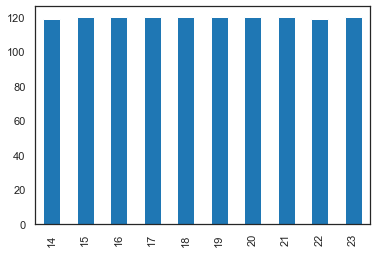

In [29]:
# plot number of files per hour in 2.8 (should be ~120 files per hour)
files_28 = [os.path.basename(x) for x in Path(siri_28_dir).rglob('*.json')]  # recursive search
print(len(files_28))

files_hour_28 = [x.split('-09T')[1].split('.')[0][:2] for x in files_28]
pd.Series(files_hour_28).value_counts().sort_index().plot.bar()
plt.show()


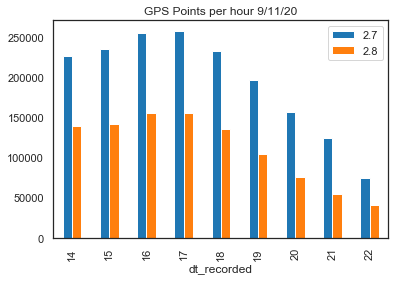

In [30]:
# Points per hour
hour_27 = df_27_final_dedup.groupby(df_27_final_dedup.dt_recorded.dt.hour).size().rename('2.7')
hour_28 = df_28_final_dedup.groupby(df_28_final_dedup.recorded_at_time.dt.hour).size().rename('2.8')

hour_27.to_frame().join(hour_28).plot.bar(figsize=(6, 4))
plt.title('GPS Points per hour 9/11/20')
plt.show()

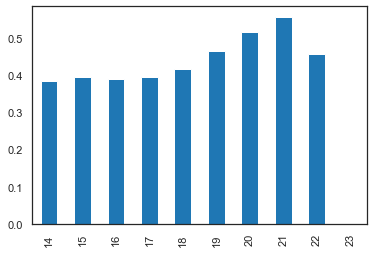

In [31]:
(1 - (hour_28/hour_27)).plot.bar(figsize=(6, 4))
plt.show()

In [32]:
hour_28.sum() / hour_27.sum()

0.5857931670989609

2.8 has 42% less GPS points than 2.7, this is consistent across hours (39-55% less points per hour)

## GPS points comparison

In [33]:
# When grouping by agency
agency_27 = df_27_final_dedup.groupby('agency_id').size().rename('2.7')
agency_28 = df_28_final_dedup.groupby('operator_ref').size().rename('2.8')


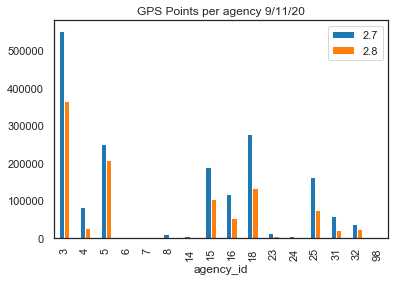

In [34]:
agency_27.to_frame().join(agency_28).plot.bar(figsize=(6, 4))
plt.title('GPS Points per agency 9/11/20')

plt.show()

In [35]:
(1 - (agency_28/agency_27)).sort_values()

6     0.169769
5     0.177289
7     0.225268
14    0.315186
3     0.337620
32    0.407086
15    0.451375
18    0.522849
25    0.546423
16    0.547971
31    0.638895
23    0.644865
4     0.672433
8     0.709886
24    0.931918
2          NaN
98         NaN
dtype: float64

## Rides comparison

In [36]:
df_27_final_rides.shape[0], df_28_final_rides.shape[0]

(47336, 38395)

In [37]:
df_28_final_rides.shape[0] / df_27_final_rides.shape[0]

0.8111162751394287

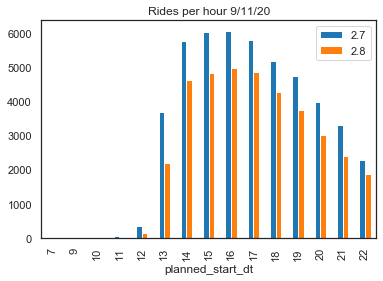

In [38]:
# Points per hour
hour_27_r = df_27_final_rides.groupby(
    df_27_final_rides.planned_start_dt.dt.hour).size().rename('2.7')
hour_28_r = df_28_final_rides.groupby(
    df_28_final_rides.origin_aimed_departure_time.dt.hour)\
    .size().rename('2.8')

hour_27_r.to_frame().join(hour_28_r).plot.bar(figsize=(6, 4))
plt.title('Rides per hour 9/11/20')
plt.show()

In [39]:
# When grouping by agency
agency_27_r = df_27_final_rides.groupby('agency_id').size().rename('2.7')
agency_28_r = df_28_final_rides.groupby('operator_ref').size().rename('2.8')


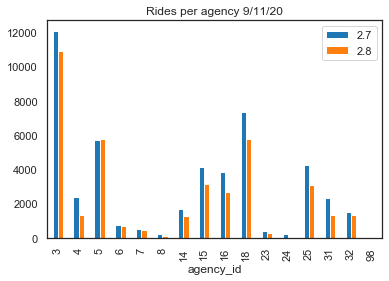

In [40]:
agency_27_r.to_frame().join(agency_28_r).plot.bar(figsize=(6, 4))
plt.title('Rides per agency 9/11/20')

plt.show()

In [41]:
(1 - (agency_28_r / agency_27_r)).sort_values()

5    -0.014776
3     0.096459
6     0.133333
32    0.142295
7     0.144465
18    0.210060
15    0.230844
14    0.238959
25    0.267093
16    0.295425
23    0.306533
4     0.429297
31    0.431986
8     0.497653
24    0.780083
2          NaN
98         NaN
dtype: float64

In [52]:
routes_27 = set(df_27_final_rides[df_27_final_rides.points_cnt > 10]
                .route_id.values)
routes_28 = set(df_28_final_rides[df_28_final_rides.points_cnt > 10]
                .line_ref.values)

missing_routes_no28_yes27 = routes_27 - routes_28

extra_routes_no27_yes28 = routes_28 - routes_27

print("Number of route ids with at least 1 ride of 10 points:",
      "Siri 2.7: {}".format(len(routes_27)),
      "Siri 2.8: {}".format(len(routes_28)),
      "Missing routes (appear in 2.7 but not in 2.8): {}".format( 
      len(missing_routes_no28_yes27)),
      "Extra routes (appear in 2.8 but not in 2.7): {}".format( 
      len(extra_routes_no27_yes28)),
     sep='\n\t')

Number of route ids with at least 1 ride of 10 points:
	Siri 2.7: 3546
	Siri 2.8: 1987
	Missing routes (appear in 2.7 but not in 2.8): 1627
	Extra routes (appear in 2.8 but not in 2.7): 68


In [73]:
routes_27 = set(df_27_final_rides.route_id.values)
routes_27 = {int(x) for x in routes_27} # cast for json serializability
routes_28 = set(df_28_final_rides.line_ref.values)
routes_28 = {int(x) for x in routes_28} # cast for json serializability

missing_routes_no28_yes27 = routes_27 - routes_28

extra_routes_no27_yes28 = routes_28 - routes_27

print("Number of route ids:",
      "Siri 2.7: {}".format(len(routes_27)),
      "Siri 2.8: {}".format(len(routes_28)),
      "Missing routes (appear in 2.7 but not in 2.8): {}".format( 
      len(missing_routes_no28_yes27)),
      "Extra routes (appear in 2.8 but not in 2.7): {}".format( 
      len(extra_routes_no27_yes28)),
     sep='\n\t')


routes_dict = {
    'routes_2.7': sorted(list(routes_27)),
    'routes_2.8': sorted(list(routes_28)),
    'missing_routes_no2.8_yes2.7': sorted(list(missing_routes_no28_yes27)),
    'extra_routes_no2.7_yes2.8': sorted(list(extra_routes_no27_yes28)),
}

with open('route_ids_siri_27_28.json', 'w') as f:
    json.dump(routes_dict, f, indent=2)
    print(dt.datetime.now(), "json saved for all route ids")

Number of route ids:
	Siri 2.7: 4195
	Siri 2.8: 2775
	Missing routes (appear in 2.7 but not in 2.8): 1476
	Extra routes (appear in 2.8 but not in 2.7): 56
2020-11-19 18:07:49.103444 json saved for all route ids


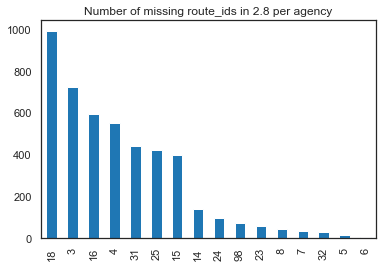

In [66]:
# missing routes per agency:
df_27_final_rides[df_27_final_rides.route_id.isin(missing_routes_no28_yes27)]\
    .agency_id.value_counts().plot.bar()
plt.title("Number of missing route_ids in 2.8 per agency")
plt.show()

In [72]:
# missing routes with most rides in 2.7:
df_27_final_rides[df_27_final_rides.route_id.isin(missing_routes_no28_yes27)]\
    .groupby('route_id').size().sort_values(ascending=False).head(10).to_frame().rename(columns={0: 'N_rides_in_2.7'})


,N_rides_in_2.7
route_id,
26010,29
26008,25
16579,23
8211,16
2179,16
12176,16
23414,16
17577,16
11432,15


In [75]:
df_27_final_dedup[df_27_final_dedup.route_id == 26010].sort_values('dt_recorded')

,planned_start_dt,predicted_end_dt,dt_recorded,timestamp,agency_id,route_id,route_short_name,service_id,bus_id,lat,lon,stop_point_ref,date,num_duplicates
1180572,2020-11-09 14:00:00,2020-11-09 14:31:00,2020-11-09 14:00:45,2020-11-09 14:01:41,98,26010,4,50836449,7416126,32.096195,34.776039,44281,2020-11-09,1
1185215,2020-11-09 14:00:00,2020-11-09 14:31:00,2020-11-09 14:02:00,2020-11-09 14:02:41,98,26010,4,50836449,7416126,32.094944,34.775467,44281,2020-11-09,1
1189767,2020-11-09 14:00:00,2020-11-09 14:31:00,2020-11-09 14:02:59,2020-11-09 14:03:49,98,26010,4,50836449,7416126,32.092064,34.774601,44281,2020-11-09,1
1194258,2020-11-09 14:00:00,2020-11-09 14:30:00,2020-11-09 14:04:48,2020-11-09 14:05:00,98,26010,4,50836449,7416126,32.089397,34.773796,44281,2020-11-09,1
1194257,2020-11-09 13:45:00,2020-11-09 14:11:00,2020-11-09 14:04:50,2020-11-09 14:05:00,98,26010,4,0,8547326,32.060654,34.774925,44281,2020-11-09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1981074,2020-11-09 22:16:00,2020-11-09 22:39:00,2020-11-09 22:32:00,2020-11-09 22:32:13,98,26010,4,0,8959926,32.061359,34.773811,44281,2020-11-09,1
1983075,2020-11-09 22:16:00,2020-11-09 22:39:00,2020-11-09 22:32:59,2020-11-09 22:33:13,98,26010,4,0,8959926,32.060749,34.774128,44281,2020-11-09,1
1984899,2020-11-09 22:16:00,2020-11-09 22:39:00,2020-11-09 22:33:57,2020-11-09 22:34:13,98,26010,4,0,8959926,32.060642,34.776756,44281,2020-11-09,1
1986781,2020-11-09 22:16:00,2020-11-09 22:40:00,2020-11-09 22:34:58,2020-11-09 22:35:13,98,26010,4,0,8959926,32.058125,34.777122,44281,2020-11-09,1


In [57]:
# Do the missing rides belong to the missing routes?
agency_27_r2 = df_27_final_rides[
    ~df_27_final_rides.route_id.isin(missing_routes)]\
    .groupby('agency_id').size().rename('2.7')


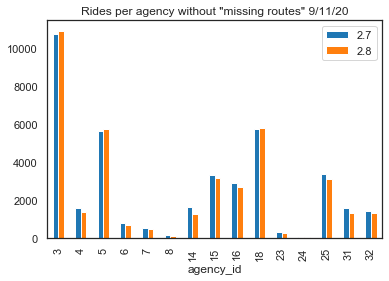

In [58]:
agency_27_r2.to_frame().join(agency_28_r).plot.bar(figsize=(6, 4))
plt.title('Rides per agency without "missing routes" 9/11/20')

plt.show()

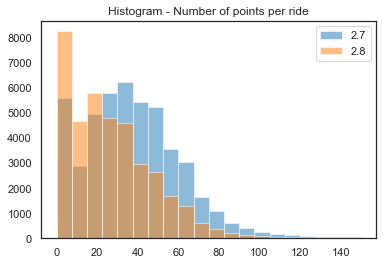

In [70]:
# number of points per ride:
fig, ax = plt.subplots(1,1)

df_27_final_rides.points_cnt.hist(bins=20, ax=ax, alpha=0.5, 
                                  label='2.7', range=(0, 150))
df_28_final_rides.points_cnt.hist(bins=20, ax=ax, alpha=0.5, 
                                  label='2.8', range=(0, 150))

plt.legend()
plt.grid(False)
plt.title('Histogram - Number of points per ride')
plt.show()